<a href="https://colab.research.google.com/github/deepmorzaria/Physics-Informed-Neural-Network-PINNs---TF-2.0/blob/master/PINNs_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade pyDOE


  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=1568ae1a334572156f7801c518026ccab13b5b72ed0fdea57e10bca427c25a43
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#These contain data for the actual output of PDE at t=0.25,0.50,0.75 which would later used to compare with the predicted output of neural network
actual_outputs_1 = pd.read_excel (r'gdrive/My Drive/Colab Notebooks/actual outputs/t=0.25.xlsx')
actual_outputs_2 = pd.read_excel (r'gdrive/My Drive/Colab Notebooks/actual outputs/t=0.50.xlsx')
actual_outputs_3 = pd.read_excel (r'gdrive/My Drive/Colab Notebooks/actual outputs/t=0.75.xlsx')

In [ ]:
data = loadmat('gdrive/My Drive/Colab Notebooks/burgers_shock.mat')


In [ ]:
#Extracting input and outputs from data
x=data['x']  # (256,1)      x varies from [-1,1]
t=data['t']  # (100,1)      t varies from [0,1]
Exact=data['usol'].T     #(100,256)

In [ ]:
X,T=np.meshgrid(x,t) # X-(100,256)  T-(100,256)
X_star=np.hstack((X.flatten()[:,None],T.flatten()[:,None])) # flatten() will return a list of numbers. [:,None] converts it to list of list. Refer to numpy.hstack syntax for more details.
u_star = Exact.flatten()[:,None]              

# X_star (25600,2) Set of points for each time instant 
# u_star (25600,1) ouputs for each (x,t)


In [ ]:
xx1=np.hstack((X[0:1,:].T,T[0:1,:].T))  # data for initial boundary condition   (256,2)
xx2=np.hstack((X[:,0:1],T[:,0:1]))      # data for boundary condition for x=-1  (100,2)
xx3=np.hstack((X[:,-1:],T[:,-1:]))      # data for boundary condition for x=1   (100,2)

uu1 = Exact[0:1,:].T
uu2 = Exact[:,0:1]
uu3 = Exact[:,-1:]
    

In [ ]:
lb = X_star.min(axis=0)    # (1,2)   [-1 0]
ub = X_star.max(axis=0)    # (1,2)   [1 0.99]
no_of_interior_points=8000
no_of_collocation_points=100

X_u_train = np.vstack([xx1, xx2, xx3])                           # (456,2) stacking up all data related to bc's  
X_f_train = lb + (ub-lb)*lhs(2, no_of_interior_points)           # (8000,2) lhs is used to generate random sample of points. 2 is no of variables(x,t).
X_f_train = np.vstack((X_f_train, X_u_train))                    # (no_of_interior_points + 456,2)
u_train = np.vstack([uu1, uu2, uu3])                             # (456,1) correspoing to X_u_train

In [ ]:
idx = np.random.choice(X_u_train.shape[0], no_of_collocation_points , replace=False) # random sample of collocation points from 456 numbers 
X_u_train = X_u_train[idx, :]                                                        # Those collocation points chosen from boundary conditions data
u_train = u_train[idx,:]                                                             # Output corresponding to collocation points

In [ ]:
X_u_train.shape
X_f_train.shape

(8456, 2)

In [ ]:
# subscript u denotes collocation/boundary points and subscript f denotes interior points
x_u = X_u_train[:,0:1]       #Separating x,t from X_u_train
t_u = X_u_train[:,1:2]
x_f = X_f_train [:,0:1]
t_f = X_f_train [:,1:2]


In [ ]:
x_u_tf=tf.Variable(x_u)       #Converting to tensor varialble. Essential for calculating gradients later on.
t_u_tf=tf.Variable(t_u)
x_f_tf=tf.Variable(x_f)
t_f_tf=tf.Variable(t_f)
X_f_train_tf=tf.Variable(X_f_train)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
def get_model():
  model=Sequential([
                    Dense(20,activation='tanh',kernel_initializer=tf.keras.initializers.GlorotNormal(),input_shape=(2,),name='H1')
  ])
  
  for i in range(6):
    model.add(Dense(20,activation='tanh',kernel_initializer=tf.keras.initializers.GlorotNormal(),name='H'+str(i+2)))

  model.add(Dense(1,name='output_layer'))

  return model


In [ ]:
model=get_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 20)                60        
_________________________________________________________________
H2 (Dense)                   (None, 20)                420       
_________________________________________________________________
H3 (Dense)                   (None, 20)                420       
_________________________________________________________________
H4 (Dense)                   (None, 20)                420       
_________________________________________________________________
H5 (Dense)                   (None, 20)                420       
_________________________________________________________________
H6 (Dense)                   (None, 20)                420       
_________________________________________________________________
H7 (Dense)                   (None, 20)               

In [ ]:
#function for calculating loss wrt to interior points
def interior_loss():
 
  with tf.GradientTape() as tape:
    tape.watch(X_f_train_tf)
    with tf.GradientTape() as tape2:
      u_predicted=model(X_f_train_tf)
    grad=tape2.gradient(u_predicted,X_f_train_tf)
    du_dx=grad[:, 0]
    du_dt=grad[:, 1]
  j = tape.gradient(grad, X_f_train_tf)
  d2u_dx2 = j[:,0]
  
  u_predicted=tf.cast(u_predicted, dtype=tf.float64)
  du_dx=tf.reshape(du_dx, [no_of_interior_points+456,1])
  d2u_dx2=tf.reshape(d2u_dx2, [no_of_interior_points+456,1])
  du_dt=tf.reshape(du_dt, [no_of_interior_points+456,1])

  f= du_dt + u_predicted*du_dx - (0.01/3.14*d2u_dx2)  
  f=tf.math.reduce_mean(tf.math.square(f))

  return f



In [ ]:
"""
LBFG-S, which is second order optimizer, has been used to update the weights and biases because conventional first order optimizers Adam, Gradient descent and RMSprop 
are slow to converge.LBFG-S is not available by default in Tensorflow 2.0 and hence a function from Tensorflow Probability has been used. This has not been coded by me
except for a minor addition to loss function(check the loss_value variable). Please refer to the link below to get a better idea.

https://gist.github.com/piyueh/712ec7d4540489aad2dcfb80f9a54993

"""
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot

def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)
            int_loss=interior_loss()
            loss_value=loss_value+int_loss


        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f


def plot_helper(inputs, outputs, title, fname):

    pyplot.figure(figsize=(8,4))
    pyplot.tricontourf(inputs[:, 1], inputs[:, 0], outputs.flatten(), 100)
    pyplot.scatter(X_u_train[:, 1], X_u_train[:, 0],marker='x',s=100,c='k')
    pyplot.xlabel("t")
    pyplot.ylabel("x")
    pyplot.title(title)
    pyplot.colorbar()
    pyplot.savefig(fname)



In [ ]:
tf.keras.backend.set_floatx("float64")
func = function_factory(model, tf.keras.losses.MeanSquaredError() ,X_u_train , u_train)
init_params = tf.dynamic_stitch(func.idx, model.trainable_variables)
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=func, initial_position=init_params, max_iterations=1000)


Iter: 1 loss: 0.25891476594969909
Iter: 2 loss: 2.5217619072370594
Iter: 3 loss: 0.837469576452309
Iter: 4 loss: 0.25427786838700372
Iter: 5 loss: 0.20462727953223722
Iter: 6 loss: 0.74172158861345061
Iter: 7 loss: 0.20457109752097066
Iter: 8 loss: 0.20214533174457811
Iter: 9 loss: 0.22515200480304437
Iter: 10 loss: 0.20207150982854988
Iter: 11 loss: 0.20180439202476114
Iter: 12 loss: 0.20100295716331734
Iter: 13 loss: 0.20368877522379231
Iter: 14 loss: 0.20061571783668683
Iter: 15 loss: 0.19766184204795778
Iter: 16 loss: 0.18637086340737413
Iter: 17 loss: 0.22555800529580944
Iter: 18 loss: 0.17973467154710876
Iter: 19 loss: 0.17053506538033131
Iter: 20 loss: 0.16964654602792281
Iter: 21 loss: 0.16386027471361375
Iter: 22 loss: 0.20642340160570954
Iter: 23 loss: 0.16319699638000254
Iter: 24 loss: 0.15796963676179504
Iter: 25 loss: 0.1952160312645517
Iter: 26 loss: 0.15712273527587475
Iter: 27 loss: 0.15381662294330173
Iter: 28 loss: 0.15263009705605129
Iter: 29 loss: 0.1506569822513576

In [ ]:
func.assign_new_model_parameters(results.position)


In [ ]:
p=np.vstack([X_f_train,X_u_train])
q=np.vstack([model.predict(X_f_train),model.predict(X_u_train)])[:,0]


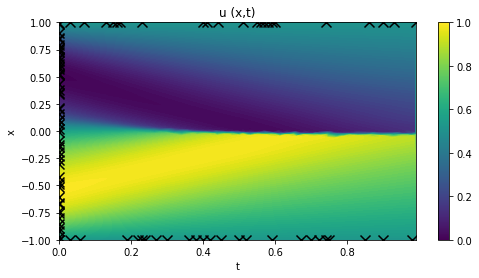

In [ ]:
plot_helper(p, q, "u (x,t)", "pred_soln3.pdf")

In [ ]:
x_t_25=np.hstack(( X[0:1,:].T, T[25:26,:].T))
x_t_50=np.hstack(( X[0:1,:].T, T[50:51,:].T))
x_t_75=np.hstack(( X[0:1,:].T, T[75:76,:].T))

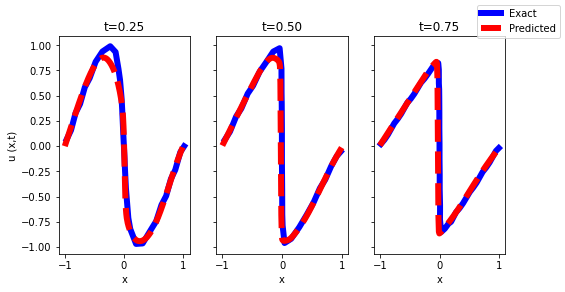

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8,4) ,sharey=True)
l1,=axs[0].plot(actual_outputs_1['x'], actual_outputs_1['t'],linewidth=6,color='b')
l2,=axs[0].plot(x_t_25[:,0],model.predict(x_t_25),linewidth=6,linestyle='dashed',color='r')
axs[0].set_title('t=0.25')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u (x,t)')


axs[1].plot(actual_outputs_2['x'],actual_outputs_2['t'],linewidth=6,color='b')
axs[1].plot(x_t_50[:,0],model.predict(x_t_50),linewidth=6,linestyle='dashed',color='r')
axs[1].set_title('t=0.50')
axs[1].set_xlabel('x')

axs[2].plot(actual_outputs_3['x'], actual_outputs_3['t'],linewidth=6,color='b')
axs[2].plot(x_t_75[:,0],model.predict(x_t_75),linewidth=6,linestyle='dashed',color='r')
axs[2].set_title('t=0.75')
axs[2].set_xlabel('x')

#line_labels = ['Exact','Predicted']

fig.legend(handles=(l1,l2),labels=('Exact','Predicted'),loc='upper right')
pyplot.savefig('graphs3.pdf')


In [ ]:
r=model.predict(X_u_train)


In [ ]:
error_u = np.linalg.norm(u_train-r,2)/np.linalg.norm(u_star,2)   
print(error_u)

0.0041886803643487285
